In [1]:
import pickle
import torch
import torchtext.transforms as T
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

def loadFiles(file):
    with open(file, "rb") as file:
        data = pickle.load(file)
    print("The size of the dataset is:", len(data))
    return data


def separateData(data):
    X = data[:, 0]
    y = data[:, 1]
    return X, y

In [2]:
data = loadFiles(r'./english-german-both.pkl')

The size of the dataset is: 10000


In [3]:
eng, germ = separateData(data)

In [4]:
def findLongestSequence(sentList):
    return max(len(seq.split()) for seq in sentList)


In [5]:
enTokenizer = get_tokenizer('spacy', language='en')
deTokenizer = get_tokenizer('spacy', language='de')
def yieldTokensEn(data):
    for text in data:
        yield enTokenizer(text[:-1])

def yieldTokensDe(data):
    
    for text in data:
        yield deTokenizer(text[:-1])

/home/scotty/.local/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
/home/scotty/.local/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(


In [6]:
vocabEn = build_vocab_from_iterator(yieldTokensEn(eng), specials=["<pad>", "<sos>", "<eos>", "<unk>"], special_first=True)
vocabDe = build_vocab_from_iterator(yieldTokensDe(germ), specials=["<pad>", "<sos>", "<eos>", "<unk>"], special_first=True)

In [7]:
textPipelineEn = lambda x: vocabEn(enTokenizer(x))
textPipelineDe = lambda x: vocabDe(deTokenizer(x))

In [8]:
from sklearn.model_selection import train_test_split

trainEn, testEn, trainDe, testDe = train_test_split(eng, germ, test_size=0.1)
trainEn, valEn, trainDe, valDe = train_test_split(eng, germ, test_size=0.1)

In [9]:
BATCH_SIZE = 4
PAD_IDX = vocabEn(['<pad>'])[0]
SOS_IDX = vocabEn(['<sos>'])
EOS_IDX = vocabEn(['<eos>'])
print(PAD_IDX)
print(SOS_IDX)
print(EOS_IDX)

0
[1]
[2]


In [10]:
from torch.nn.utils.rnn import pad_sequence

def generateData(eng, deu):
    data = []
    for en, de in zip(eng, deu):
        enTensor = torch.tensor(textPipelineEn(en[:-1]), dtype=torch.long)
        deTensor = torch.tensor(textPipelineDe(de[:-1]), dtype=torch.long)
        data.append((enTensor, deTensor))
    return data


trainData = generateData(trainEn, trainDe)
valData = generateData(valEn, valDe)         
testData = generateData(testEn, testDe)        

In [11]:
from torch.utils.data import DataLoader

    
def generateBatch(data_batch):
  de_batch, en_batch = [], []
  # print(data_batch)
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor(SOS_IDX), de_item, torch.tensor(EOS_IDX)], dim=0))
    en_batch.append(torch.cat([torch.tensor(SOS_IDX), en_item, torch.tensor(EOS_IDX)], dim=0))
  deLength = len(de_batch)
  batch = pad_sequence(en_batch + de_batch, padding_value=PAD_IDX, batch_first=True)
  en_batch, de_batch = batch[:deLength], batch[deLength:]
  return de_batch, en_batch


trainIter = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generateBatch)
valIter =  DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generateBatch)
testIter = DataLoader(testData, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generateBatch)

In [12]:
from transformer import Transformer
from positenc import PositionalEncodingTorch
from torch.nn import Embedding, Module, Linear

EMB_DIM = 512
HEADS = 4
LINEAR_DIM = 2048
DROPOUT = 0.1
LAYERS = 1
BETA_1 = 0.9
BETA_2 = 0.98
EPSILON = 10**-9
ENG_VOCAB_LEN = vocabEn.__len__()
DE_VOCAB_LEN = vocabDe.__len__()
print(f"The english has {ENG_VOCAB_LEN} words.")
print(f"The german has {DE_VOCAB_LEN} words.")

EN_MAX_SEQ_LEN, DE_MAX_SEQ_LEN = findLongestSequence(eng) + 2 , findLongestSequence(germ) + 2

#mask for the decoder
def createMask(x):
    batch, seq_length, _ = x.size()
    mask = torch.ones((batch, seq_length, seq_length))
    mask = torch.tril(mask, diagonal=0)
    return mask

def createMaskGen(x):
    x = x.unsqueeze(1)
    batch, _, seq_length = x.size()
    mask = torch.ones((batch, 1, seq_length))
    maskR = torch.logical_and(mask, x)
    maskC = torch.logical_and(x.transpose(-1, 1), mask.transpose(-1, 1))
    mask = torch.multiply(maskR, maskC)
    return mask
    


class TransformerModel(Module):
    def __init__(self):
        super().__init__()
        self.embEn = Embedding(ENG_VOCAB_LEN, EMB_DIM)
        self.embDe = Embedding(DE_VOCAB_LEN, EMB_DIM)
        self.positEn = PositionalEncodingTorch(EN_MAX_SEQ_LEN, EMB_DIM)
        self.positDe = PositionalEncodingTorch(DE_MAX_SEQ_LEN, EMB_DIM)
        self.transformer = Transformer(LAYERS, EMB_DIM, EMB_DIM, HEADS, LINEAR_DIM, DROPOUT)
        self.linear = Linear(EMB_DIM, DE_VOCAB_LEN)
        
    def forward(self, eng, de):
        mask1 = createMaskGen(eng)
        eng = self.embEn(eng)
        eng = self.positEn(eng)
        mask = createMaskGen(de)
        de = self.embDe(de)
        de = self.positDe(de)
        mask2 = createMask(de)
        mask2 = torch.logical_and(mask, mask2)
        dec = self.transformer(eng, de, mask1, mask2)
        lin = self.linear(dec)    
        return lin
        






The english has 2594 words.
The german has 4167 words.


In [13]:
class TransformerLRScheduler(object):
    def __init__(self,  warmup_steps:int=10, d_model:int=512):
        self.warmup_steps = warmup_steps
        self.d_model = d_model
    
    
    def __call__(self, epoch):
        epoch = epoch + 1
        minimum = min(epoch**-0.5, epoch * ((self.warmup_steps) ** (-1.5)))
        return (self.d_model**-0.5 ) * minimum
    

In [14]:
from torch import optim
import torch.nn as nn
from torch.optim import lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel()
total_acc, total_count = 0, 0
optimizer = optim.Adam(model.parameters(), betas=(BETA_1, BETA_2), eps=EPSILON)
loss = nn.CrossEntropyLoss(ignore_index=0)
scheduler = TransformerLRScheduler(50)

In [15]:




def train(model, trainIter, 
          testIter=valIter, 
          epochs=None, 
          loss=loss, 
          optimizer=optimizer, 
          device=device, 
          scheduler=scheduler):
    model.to(device)
    
    for epoch in range(epochs):
        for i, (X,y) in enumerate(trainIter):
            model.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            out = model(X[:, 1:], y[:, :-1])
            l = loss(out.contiguous().view(-1, 4167), y[:, 1:].contiguous().view(-1))
            l.backward()
            optimizer.step()
            break
        print(f"Epoch: {epoch+1}     loss: {l}")
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                scheduler.step()
            else:
                for param_group in optimizer.param_groups:
                    lr = scheduler(epoch)
                    param_group['lr'] = lr
                

train(model, trainIter, epochs=100)

Epoch: 1     loss: 8.544022560119629
Epoch: 2     loss: 6.278221607208252
Epoch: 3     loss: 6.747853755950928
Epoch: 4     loss: 5.874876976013184
Epoch: 5     loss: 6.600347995758057
Epoch: 6     loss: 5.460968494415283
Epoch: 7     loss: 6.009016036987305
Epoch: 8     loss: 5.9075398445129395
Epoch: 9     loss: 5.353695392608643
Epoch: 10     loss: 5.691636085510254
Epoch: 11     loss: 5.960908889770508
Epoch: 12     loss: 5.210799694061279
Epoch: 13     loss: 5.5831427574157715
Epoch: 14     loss: 5.7938456535339355
Epoch: 15     loss: 5.655277729034424
Epoch: 16     loss: 5.52074670791626
Epoch: 17     loss: 5.538334369659424
Epoch: 18     loss: 6.00742769241333
Epoch: 19     loss: 6.374217987060547
Epoch: 20     loss: 5.621176719665527
Epoch: 21     loss: 5.076334476470947
Epoch: 22     loss: 5.98930025100708
Epoch: 23     loss: 5.5070390701293945
Epoch: 24     loss: 5.767589092254639
Epoch: 25     loss: 6.4994707107543945
Epoch: 26     loss: 5.458944320678711
Epoch: 27     loss:

Text(0, 0.5, 'Learning Rate')

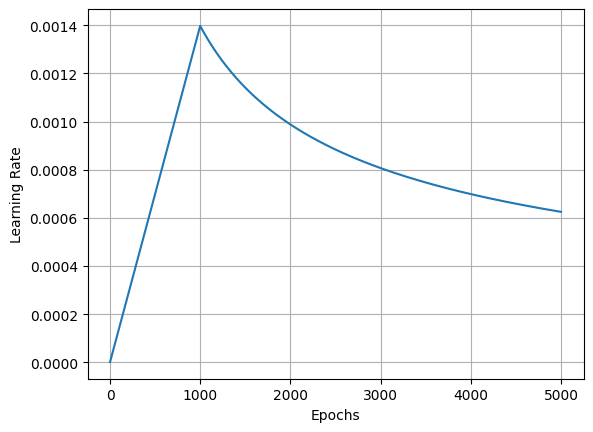

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

lr = TransformerLRScheduler(1000)
plt.plot([i for i in range(5000)], [lr(i) for i in range(5000)])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel("Learning Rate")

In [17]:
model = TransformerModel()

train(model, trainIter, epochs=1000, scheduler=None)




Epoch: 1     loss: 8.338613510131836
Epoch: 2     loss: 8.451349258422852
Epoch: 3     loss: 8.56227970123291
Epoch: 4     loss: 8.30734920501709
Epoch: 5     loss: 8.353331565856934
Epoch: 6     loss: 8.282906532287598
Epoch: 7     loss: 8.25218391418457
Epoch: 8     loss: 8.436877250671387
Epoch: 9     loss: 8.147210121154785
Epoch: 10     loss: 8.402889251708984
Epoch: 11     loss: 8.294428825378418
Epoch: 12     loss: 8.21205997467041
Epoch: 13     loss: 8.47087574005127
Epoch: 14     loss: 8.348620414733887
Epoch: 15     loss: 8.455703735351562
Epoch: 16     loss: 8.49911880493164
Epoch: 17     loss: 8.335630416870117
Epoch: 18     loss: 8.134664535522461
Epoch: 19     loss: 8.490696907043457
Epoch: 20     loss: 8.264126777648926
Epoch: 21     loss: 8.429866790771484
Epoch: 22     loss: 8.057060241699219
Epoch: 23     loss: 8.264566421508789
Epoch: 24     loss: 8.415461540222168
Epoch: 25     loss: 8.60433292388916
Epoch: 26     loss: 8.459420204162598
Epoch: 27     loss: 8.412854